In [22]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
)
from tensorflow.keras.layers import Lambda
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from colorama import Fore, Style

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Silences TensorFlow messages

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Loading & merging data functions

In [2]:
def load_load_data(mode='grouped'):
    load_history_raw = pd.read_csv("Load_history.csv")

    if mode == 'raw':
        return load_history_raw

    # step 1: prep the data for unpivoting

    # init empty df to hold prepped data
    load_data_wide = pd.DataFrame()
    
    # copy over the zone_id column (it doesn't need any prepping)
    load_data_wide['zone_id'] = load_history_raw['zone_id']
    
    # convert year, month, day columns to one date column
    load_data_wide['date'] = pd.to_datetime(load_history_raw[['year', 'month', 'day']])
    
    # bring in the hour columns
    hour_columns = [f'h{i}' for i in range(1, 25)]
    for col in hour_columns:
        load_data_wide[col] = load_history_raw[col]

    if mode == 'wide':
        return load_data_wide
    
    # step 2: unpivoting
    load_data_long = load_data_wide.melt(
        id_vars = ['zone_id', 'date'], # cols to preserve
        value_vars=hour_columns,       # cols to unpivot
        var_name='hour',               # colname for new index col (hour)
        value_name='load'              # colname for new value col (load)
    )
    
    # step 3: clean up after unpivot
    
    # convert 'hour' from string (i.e. 'h1') to numeric (i.e. 1)
    load_data_long['hour'] = load_data_long['hour'].str.extract(r'(\d+)').astype(int)
    
    # create a full datetime column by augmenting 'date' with 'hour'
    load_data_long['datetime'] = load_data_long['date'] + pd.to_timedelta(load_data_long['hour'] - 1, unit='h')

    # change dtype on 'load'
    load_data_long['load'] = (
        load_data_long['load']
        .replace(',', '', regex=True)                             # remove commas
        .apply(lambda x: x.strip() if isinstance(x, str) else x)  # strip any whitespace
        .apply(pd.to_numeric, errors='coerce')                    # convert to numeric (keeping NaNs)
    )
    
    # drop extra columns
    load_data_long = load_data_long[['zone_id', 'datetime', 'load']]

    # set datetime as index
    load_data_long.set_index('datetime', inplace=True)

    if mode == 'long':
        return load_data_long

    # step 4: repivot

    # pivot s.t. there is one column per zone
    load_data_grouped = load_data_long.pivot(columns='zone_id', values='load')

    # rename columns for clarity
    load_data_grouped = load_data_grouped.rename(columns=lambda col: f"zone_{col}" if col != 'datetime' else col)
    
    if mode == 'grouped':
        return load_data_grouped

    raise 'InvalidModeError'
    return None

def load_temp_data(mode='grouped'):
    temp_history_raw = pd.read_csv("temperature_history.csv")

    if mode == 'raw':
        return temp_history_raw
    
    # step 1: prep the data for unpivoting

    # init empty df to hold prepped data
    temp_data_wide = pd.DataFrame()
    
    # copy over the zone_id column (it doesn't need any prepping)
    temp_data_wide['station_id'] = temp_history_raw['station_id']
    
    # convert year, month, day columns to one date column
    temp_data_wide['date'] = pd.to_datetime(temp_history_raw[['year', 'month', 'day']])
    
    # bring in the hour columns
    hour_columns = [f'h{i}' for i in range(1, 25)]
    for col in hour_columns:
        temp_data_wide[col] = temp_history_raw[col]

    if mode == 'wide':
        return temp_data_wide
    
    # step 2: unpivoting
    temp_data_long = temp_data_wide.melt(
        id_vars = ['station_id', 'date'], # cols to preserve
        value_vars=hour_columns,          # cols to unpivot
        var_name='hour',                  # colname for new index col (hour)
        value_name='temp'                 # colname for new value col (temp)
    )
    
    # step 3: clean up after unpivot
    
    # convert 'hour' from string (i.e. 'h1') to numeric (i.e. 1)
    temp_data_long['hour'] = temp_data_long['hour'].str.extract(r'(\d+)').astype(int)
    
    # create a full datetime column by augmenting 'date' with 'hour'
    temp_data_long['datetime'] = temp_data_long['date'] + pd.to_timedelta(temp_data_long['hour'] - 1, unit='h')
    
    # drop extra columns
    temp_data_long = temp_data_long[['station_id', 'datetime', 'temp']]

    # set datetime as index
    temp_data_long.set_index('datetime', inplace=True)

    if mode == 'long':
        return temp_data_long
    
    # step 4: repivot

    # pivot s.t. there is one column per zone
    temp_data_grouped = temp_data_long.pivot(columns='station_id', values='temp')

    # rename columns for clarity
    temp_data_grouped = temp_data_grouped.rename(columns=lambda col: f"station_{col}" if col != 'datetime' else col)
    
    if mode == 'grouped':
        return temp_data_grouped

    raise 'InvalidModeError'
    return None

def load_all_data(dropna=True):
    # load datasets
    load_data = load_load_data()
    temp_data = load_temp_data()

    # merge datasets
    merged_data = pd.merge(load_data, temp_data, left_index=True, right_index=True, how='inner')
    if dropna:
        merged_data = merged_data.dropna()

    return merged_data

def load_zone_data(zone, dropna=True, data=None):
    if zone < 1 or zone > 20:
        raise 'DomainError'
        return None

    # make colname list
    station_cols = [f'station_{z}' for z in range(1, 12)]
    cols = [f'zone_{zone}'] + station_cols

    # case 1: no preloaded data
    if data is None:
        # load data
        load_data = load_load_data()
        load_data = load_data[f'zone_{zone}']

        # temp data
        temp_data = load_temp_data()

        # merge
        merged_data = pd.merge(load_data, temp_data, left_index=True, right_index=True, how='inner')

        # make empty df
        final_data = pd.DataFrame()

        # rename & load
        final_data['load'] = merged_data[f'zone_{zone}']

        # load the rest
        for col in station_cols:
            final_data[col] = merged_data[col]

        # dropna
        if dropna:
            final_data = final_data.dropna()

        return final_data
    # case 2: preloaded data
    else:
        # make empty df
        final_data = pd.DataFrame()

        # rename & load
        final_data['load'] = data[f'zone_{zone}']

        # load the rest
        for col in station_cols:
            final_data[col] = data[col]

        # dropna
        if dropna:
            final_data = final_data.dropna()

        return final_data

# Load data

In [3]:
data = load_all_data()

In [4]:
data

,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15,zone_16,zone_17,zone_18,zone_19,zone_20,station_1,station_2,station_3,station_4,station_5,station_6,station_7,station_8,station_9,station_10,station_11
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,16853.0,126259.0,136233.0,484.0,6829.0,133088.0,136233.0,3124.0,75243.0,23339.0,90700.0,118378.0,20673.0,21791.0,65970.0,28752.0,30645.0,200946.0,82298.0,79830.0,46.0,38.0,44.0,45.0,42.0,44.0,45.0,43.0,41.0,42.0,36.0
2004-01-01 01:00:00,16450.0,123313.0,133055.0,457.0,6596.0,129909.0,133055.0,2956.0,67368.0,22100.0,86699.0,112480.0,19666.0,21400.0,64600.0,27851.0,30461.0,195835.0,79827.0,77429.0,46.0,36.0,42.0,43.0,42.0,43.0,44.0,44.0,39.0,43.0,32.0
2004-01-01 02:00:00,16517.0,119192.0,128608.0,450.0,6525.0,125717.0,128608.0,2953.0,64050.0,21376.0,84243.0,108435.0,19020.0,20998.0,63843.0,27631.0,30197.0,194093.0,77728.0,75558.0,45.0,35.0,40.0,41.0,40.0,42.0,41.0,42.0,36.0,43.0,31.0
2004-01-01 03:00:00,16873.0,117507.0,126791.0,448.0,6654.0,124162.0,126791.0,2914.0,63861.0,21335.0,84285.0,107224.0,18841.0,21214.0,64023.0,27986.0,30264.0,194708.0,76433.0,75709.0,41.0,30.0,36.0,37.0,39.0,38.0,40.0,34.0,35.0,39.0,30.0
2004-01-01 04:00:00,17064.0,118343.0,127692.0,444.0,6977.0,125320.0,127692.0,3221.0,75852.0,21564.0,86087.0,108870.0,19310.0,21830.0,65679.0,29160.0,30907.0,202458.0,78172.0,77475.0,39.0,30.0,34.0,33.0,40.0,38.0,35.0,30.0,33.0,35.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-30 01:00:00,11559.0,141159.0,152311.0,324.0,5391.0,146550.0,152311.0,2393.0,63357.0,71309.0,111029.0,139035.0,13902.0,18225.0,49935.0,25591.0,28803.0,178118.0,59838.0,70839.0,74.0,65.0,76.0,72.0,74.0,70.0,73.0,71.0,72.0,70.0,65.0
2008-06-30 02:00:00,11081.0,135947.0,146687.0,313.0,4933.0,140880.0,146687.0,2291.0,63315.0,69140.0,105139.0,129338.0,13185.0,17049.0,47885.0,23733.0,27561.0,165406.0,55466.0,67356.0,74.0,64.0,76.0,72.0,74.0,70.0,72.0,71.0,72.0,70.0,64.0
2008-06-30 03:00:00,10798.0,133739.0,144304.0,299.0,4716.0,138454.0,144304.0,2234.0,63777.0,67560.0,100889.0,122493.0,13061.0,16415.0,47092.0,22653.0,27188.0,159075.0,53076.0,66952.0,74.0,64.0,75.0,72.0,73.0,70.0,71.0,71.0,69.0,70.0,64.0


# LSTM CNN

## Model Constructor Def

In [5]:
# sequence_length: number of timesteps in the sequence
#     feature_dim: number of features in each timestep
def lstm_cnn(sequence_length, feature_dim, show=False):
    # define shape of input
    input_shape = (sequence_length, feature_dim)
    
    # construct input layer
    inputs = Input(shape=input_shape)

    # construct CNN layers
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # Define a Lambda layer to reshape the CNN output for LSTM
    lstm_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(cnn)
    
    # construct LSTM layers
    lstm = LSTM(64, return_sequences=False)(lstm_input)

    # Fully connected layers
    dense = Dense(128, activation='relu')(lstm)
    dense = Dropout(0.5)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)  # For binary classification

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Summary of the model
    if show:
        print(model.summary())

    # Return
    return model

## Cross-Validation

### Functions

In [6]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        end = i + sequence_length
        X.append(data.iloc[i:end, 1:])  # Predictors
        y.append(data.iloc[i + sequence_length, 0])    # Response
    return np.array(X), np.array(y)

class CustomTqdm(tqdm):
    def update_color(self, completed_fraction):
        # Compute color between grey and pink
        grey_to_pink = Fore.LIGHTWHITE_EX if completed_fraction < 0.5 else Fore.MAGENTA
        self.set_description(f"{Style.BRIGHT}{grey_to_pink}{self.desc}{Style.RESET_ALL}")

In [13]:
def cross_validate_sequence_length(data, sequence_lengths, model_fn, n_splits=5, verbose=False, full=False, show_pbar=True):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}
    full_results = pd.DataFrame(columns=['seq_len', 'zone_id', 'RMSE'])

    seq_counter = 0
    verbose_counter = 0
    num_models = len(sequence_lengths) * 20 * n_splits + len(sequence_lengths) * 20 + len(sequence_lengths)
    with CustomTqdm(tqdm(total=num_models, desc='Starting the Werk 💼')) as pbar:
        for seq_len in sequence_lengths:
            if show_pbar:
                seq_counter += 1
                pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Starting the Werk 🔨')
            if verbose:
                if not show_pbar:
                    seq_counter += 1
                print(f'Testing sequence length: {seq_len} ({seq_counter}/{len(sequence_lengths)})...')
            
            zone_results = []
            zone_rows = []
            
            for zone in range(1,21):
                if verbose:
                    verbose_counter += 1
                    print(f'Testing zone: {zone} ({zone}/20) ({tot_counter}/{20*len(sequence_lengths)} [{(tot_counter/(20*len(sequence_lengths)))*100}%])...')
                if show_pbar:
                    completed_fraction = pbar.n / pbar.total
                    pbar.update_color(completed_fraction)
                    pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Constructing Zone {zone} Dataset ({zone}/20) 🚧')
                    
                # construct dataset
                zone_data = load_zone_data(zone=zone, data=data)
                X, y = create_sequences(zone_data, seq_len)
                
                if show_pbar:
                    pbar.update(1)
                    pbar.
                
                errors = []
    
                split_counter = 0
                for train_idx, val_idx in tscv.split(X):
                    X_train, X_val = X[train_idx], X[val_idx]
                    y_train, y_val = y[train_idx], y[val_idx]

                    if show_pbar:
                        split_counter+=1
                        completed_fraction = pbar.n / pbar.total
                        pbar.update_color(completed_fraction)
                        pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) zone: {zone}/20 Training Model {split_counter}/{n_splits} 🏋️‍♂️')
                    # Build and train the model
                    model = model_fn(seq_len, X.shape[2])
                    model.fit(X_train, y_train, epochs=5, verbose=0)  # Adjust epochs as needed
                    if show_pbar:
                        pbar.update(0.5)
                        pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) zone: {zone}/20 Evaluating Model {split_counter}/{n_splits} 🎯')
        
                    # Evaluate the model
                    y_pred = model.predict(X_val, verbose=0)
                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                    errors.append(rmse)
                    if show_pbar:
                        pbar.update(0.5)
        
                # Average validation error for this sequence length on this zone
                zone_results.append(np.mean(errors))
                if full:
                    zone_rows.append({'seq_len': seq_len, 'zone_id': zone, 'RMSE': zone_results[-1]})
                if verbose:
                    print(f'mean error for seq_len {seq_len} ({seq_counter}/{len(sequence_lengths)}) on zone {zone}: {zone_results[-1]}')
    
            # Average validation error for this sequence length
            if show_pbar:
                    pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Saving Results 💾')
            results[seq_len] = np.mean(zone_results)
            if full:
                new_df = pd.DataFrame(zone_rows)
                full_results = pd.concat([full_results, new_df], ignore_index=True)
            if verbose:
                print(f'mean error for seq_len {seq_len}: {results[seq_len]}')
            if show_pbar:
                pbar.update(1)
    if show_pbar:
        pbar.set_description(f'Finishing Off 📓')
    return results, full_results

### Execution

In [14]:
sequence_lengths = [7, 14, 30]
short_results, full_results = cross_validate_sequence_length(data, sequence_lengths, lstm_cnn, full=True)

Starting the Werk 💼:   0%|          | 0/363 [00:00<?, ?it/s]

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━

/var/folders/8p/n7h1f0bs5p76sqs_h3lhg9ph0000gn/T/ipykernel_2040/4044880390.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_results = pd.concat([full_results, new_df], ignore_index=True)


199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
199/199 ━━━━━━━━

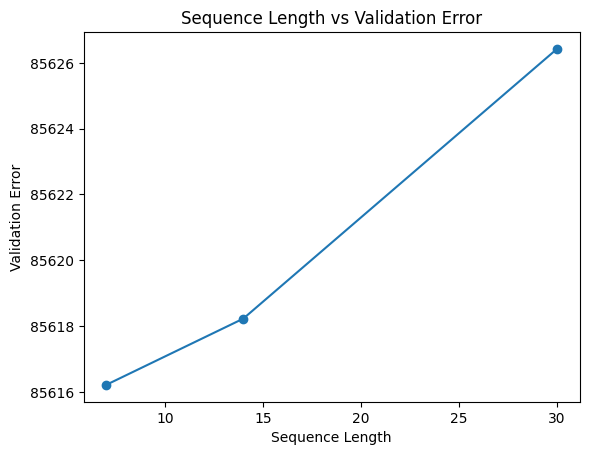

In [16]:
plt.plot(sequence_lengths, [short_results[seq] for seq in sequence_lengths], marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Validation Error')
plt.title('Sequence Length vs Validation Error')
plt.show()

In [24]:
def plot_heatmap(data, cmap="coolwarm"):
    """
    Plots a heatmap from a DataFrame with columns 'seq_len', 'zone_id', 'RMSE'.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - cmap (str): The colormap for the heatmap.

    Returns:
    - None: Displays the heatmap.
    """
    # Pivot the data to get the matrix format for heatmap
    heatmap_data = data.pivot(index='zone_id', columns='seq_len', values='MSE')

    # Plot the heatmap
    plt.figure(figsize=(12, 8))  # Adjust the size as needed
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, cbar_kws={'label': 'MSE'})
    plt.title("Heatmap of MSE by Zone and Sequence Length", fontsize=16)
    plt.xlabel("Zone ID", fontsize=14)
    plt.ylabel("Sequence Length", fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

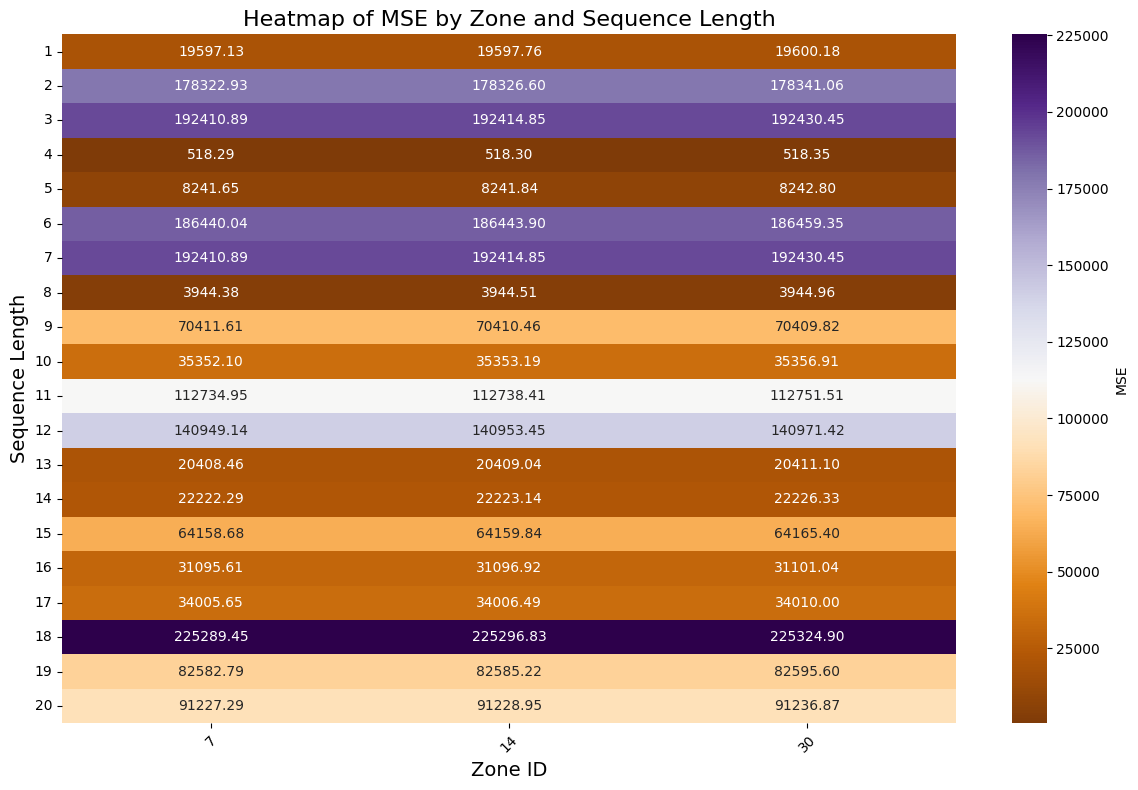

plot outputted


In [28]:
plot_heatmap(full_results, cmap='PuOr')
print('plot outputted')

### Dec 5 Results
they took 5 hours to run so I refuse to delete them

In [ ]:
# Preserving the results that took 5 hours to run
sequence_lengths_dec_5 = [7, 14, 30, 90, 180, 365]
results_dec_5 = {
    7: 12683474719.592735,
    14: 12684031588.056734,
    30: 12686099109.588818,
    90: 12691640973.167942,
    180: 12703425464.958973,
    365: 12728299830.723425
}

In [ ]:
plt.plot(sequence_lengths_dec_5, [results_dec_5[seq] for seq in sequence_lengths_dec_5], marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Validation Error')
plt.title('Sequence Length vs Validation Error')
plt.show()